# W6 Lab Exercise
This is the lab exercise for MIS590: Information Retrieval. </br>
In this lab, you will gain the following experience:</br>
- Understand how to fine-tune a pre-trained BERT model for a specific task using a sample dataset.
- Apply the fine-tuned BERT model to rank documents based on their relevance to a given query.
- Evaluate model performance of the fine-tuned model by comparing its output with expected relevance results.
</br>

**Note:** When you see a pencil icon ✏️ in this notebook, it's time for you to code or answer the question!

# 1. Preliminaries

## 1.1 Lab Activity Description

## 1.2 Install and Import Libraries

In [ ]:
# Install necessary libraries
!pip install transformers datasets torch
!pip install pytrec_eval
!pip install bertviz

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from datasets import Dataset
import random
import pytrec_eval
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from bertviz import head_view

Make sure you are using GPU!

In [ ]:
# Check if GPU is loaded
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and selected as the device.")
else:
    device = torch.device("cpu")
    print("GPU not found, using CPU instead.")

GPU is available and selected as the device.


## 1.3 Input: Query & Document Collections (Corpus)

In [ ]:
query = "sleep deprivation"
corpus = [
   "Sleepless nights in the lab have become my new normal. I tried to fix the experiment setup, but the apparatus seems to have a mind of its own. My advisor says results are just around the corner, but the corner keeps moving. Coffee is my only true companion these days.",
    "I thought grad school would be intellectually stimulating, but it's mostly paperwork and waiting for emails. The departmental printer jammed again, and now I'm late for a meeting. The cafeteria ran out of the good snacks, so I'm surviving on vending machine chips. Sleep has become a luxury I can no longer afford.",
    "Writing the dissertation feels like climbing an endless mountain. Every time I finish a chapter, my supervisor suggests new revisions. The impostor syndrome is real, and I wonder if they made a mistake accepting me. Maybe I should have gone to clown college instead. I am utterly deprived of any semblance of a normal life.",
    "My research data got corrupted, and now I have to start over. The lab mouse escaped, and we spent hours trying to find it. The grant proposal deadline is tomorrow, and the online submission portal is down. At least my pet cactus hasn't died yet.",
    "The group meeting turned into a three-hour debate over font choices for the presentation. I'm pretty sure my colleague is stealing my lunch from the fridge. The photocopier is out to get me; it never works when I'm in a hurry. Is there a PhD in napping? Because I'd ace that.",
    "I haven't seen the sun in days due to endless coding sessions. The simulation keeps crashing, and Stack Overflow doesn't have the answers. My roommate thinks I'm a ghost haunting the apartment. Instant noodles have become my primary food group.",
    "Attending conferences sounded fun until I realized they involve a lot of awkward networking. I accidentally spilled coffee on a famous professor's shoes. My poster fell down twice during the session. Next time, I'll just send a cardboard cutout of myself.",
    "The university gym membership was supposed to keep me healthy, but I've only used it once. I tried to attend a yoga class after staying up late for a deadline, but I fell asleep during the meditation. Maybe instead of the gym, my bed is more essential for keeping me healthy.",
    "My teaching assistantship involves grading endless stacks of exams. Students keep emailing me for extensions with creative excuses. One claimed their dog sleeps on the laptop so they cannot use it for the exam. I was deprived of excuses for not completing my dissertation draft, and I might have got some good ones.",
    "Group projects are the worst when you're the only one doing the work. My team members are as elusive as Bigfoot. The project is due next week, and I haven't heard from them. Perhaps I should just write a paper on the sociological implications of group work avoidance."
]

# Binary labels for the documents' relevancy to the query
# Relevant ones: 1, 2, 5, 6, 8
example_labels = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0]

# 2. IR with Pretrained BERT

## 2.1 Load Pre-trained BERT Model

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)

# Move model to GPU
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### ✏️ Observe the results above and discuss the following:
- In our last lab exercise, we load the BERT model using the following line of code: <br />
`model = BertModel.from_pretrained(model_name)` <br />
However, this time we load BERT using `BertForSequenceClassification`. Can you tell the differences between them? You should be able to see what components are in a BertForSequenceClassification model above.

In [ ]:
# Function to generate BERT embeddings for a given text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward
    with torch.no_grad():
        outputs = model(**inputs)

    # Access the last hidden state and the embedding for the [CLS] token
    return outputs.hidden_states[-1][:, 0, :]

### ✏️ Observe the results above and discuss the following:
- We access the last hidden state and the embedding for the [CLS] token from `outputs.hidden_states[-1][:, 0, :]`. What is in `outputs.hidden_states`?

### ✏️ answer：
在 BERT 中，outputs.hidden_states 是一個張量，每個張量對應於 BERT 模型一層的隱藏狀態, 其中包含輸入的每個 transformer 中的隱藏層, 這些隱藏狀態表示輸入文本在通過 BERT 模型的每一層時的中間表示（嵌入）。

## 2.2 Compute BERT Embeddings

In [ ]:
# Compute BERT embeddings for the query
query_embedding = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings = [get_bert_embedding(doc) for doc in corpus]

### Measuring similarity: cosine similarity

In [ ]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    vec1 = vec1.numpy()
    vec2 = vec2.numpy()
    dot_product = np.dot(vec1, vec2.T)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

### Rank the documents using cosine similarity

In [ ]:
# Rank documents based on similarity to the query
rankings_BERT = []

for idx, doc_embedding in enumerate(corpus_embeddings):
    # Move the embeddings back to cpu so we can compute their cosine similarity
    score = cosine_similarity(query_embedding[0].cpu(), doc_embedding[0].cpu())
    rankings_BERT.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_BERT_srt = sorted(rankings_BERT, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_BERT_srt, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings:
Rank 1: Document 2 with score 0.8103366494178772
Rank 2: Document 6 with score 0.7880861163139343
Rank 3: Document 5 with score 0.7864928245544434
Rank 4: Document 3 with score 0.7857747673988342
Rank 5: Document 1 with score 0.7844797968864441
Rank 6: Document 10 with score 0.7754189372062683
Rank 7: Document 7 with score 0.7519575357437134
Rank 8: Document 8 with score 0.7409098148345947
Rank 9: Document 4 with score 0.7397840619087219
Rank 10: Document 9 with score 0.7047695517539978


## 2.3 Measure Performance

### Average Precision

In [ ]:
# Compute Average Precision (AP) using pytrec_eval package

# Define relevance judgments. These are the documents that are actually relevant to the query
qrel = {
    'q1': {
        'doc1': 1,
        'doc2': 1,
        'doc5': 1,
        'doc6': 1,
        'doc8': 1
    }
}

# Define retrieval results with scores, ensuring scores are native Python floats, not numpy floats
q1 = {"doc"+str(i+1): float(rankings_BERT[i][1]) for i in range(0,10)}

# Define retrieval results with scores
run = {
    'q1': q1
}

evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'map'})
results = evaluator.evaluate(run)
print(f"Average Precision (pytrec_eval): {results['q1']['map']:.4f}")

Average Precision (pytrec_eval): 0.8850


### ✏️ Observe the results above and discuss the following:
- What is the difference between this AP score and that computed by sklearn.metric.average_precision_score?

### ✏️ Answer：
由 pytrec_eval 計算的AP評估文檔的整個排名，這意味著不僅相關文檔很重要，而且它們出現的順序也很重要。排名較高的相關文件將對AP分數做出更積極的貢獻。
平均精度均值 （MAP）：它計算排名清單中每個相關文件位置的精度，並取這些精度值的平均值。
sklearn.metrics.average_precision_score 中的AP分主要用於二元分類任務,  評估二元分類的精度-召回率曲線，側重於基於分數的閾值，而不是顯式閾值

# 3. IR with Fine-Tuned BERT



## 3.1 Load the corpus for fine-tuning

### We will be using two different datasets during the fine-tuning process

*   **Training dataset:** For tuning the parameters of BERT.
*   **Evaluation dataset:** For choosing the best fine-tuned model.

**✏️ Upload Corpus.tsv and Eval.tsv**


In [ ]:
# Load training corpus and label
corpus_FT = []
labels = []

with open("./Corpus.tsv", "r") as f:
    for line in f.readlines():
      parts = line.strip().split("\t")

      if len(parts) == 2:
          corpus_FT.append(parts[0])
          labels.append(int(parts[1]))

In [ ]:
# Load eval dataset
eval_corpus = []
eval_labels = []

with open("./Eval.tsv", "r") as f:
    for line in f.readlines():
      parts = line.strip().split("\t")

      if len(parts) == 2:
          eval_corpus.append(parts[0])
          eval_labels.append(int(parts[1]))

In [ ]:
print(f"Number of training instances: {len(corpus_FT)}")
print(f"Number of evaluation instances: {len(eval_corpus)}")


Number of training instances: 127
Number of evaluation instances: 20


### ✏️ Observe the results above and discuss the following:
- How many instances are there in the training set?
- How many are there in the evaluation set?
- Why is one of the dataset significantly larger than another?

### ✏️ Answer：
Number of training instances: 127

Number of evaluation instances: 20

訓練集通常會比驗證集或測試集還大，因為模型需要大量的數據來學習跟泛化，而評估數據只是用來評估模型性能

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# Prepare dataset
data = {'text': corpus_FT, 'label': labels}
dataset = Dataset.from_dict(data)
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Prepare evaluation dataset
eval_data = {'text': eval_corpus, 'label': eval_labels}
eval_dataset = Dataset.from_dict(eval_data)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

## 3.2 Fine-Tune BERT

In [ ]:
# Fine-Tune BERT

eval_step = 10

# Set up the arguements for fine-tuning
training_args = TrainingArguments(
    output_dir='./results', # Output directory
    num_train_epochs=3, # Number of training epochs
    per_device_train_batch_size=4, # Batch size for training
    per_device_eval_batch_size=8, # Batch size for evaluation
    warmup_steps=10, # Number of warmup steps
    weight_decay=0.01, # We will assign the gradient smaller and smaller weights as the training goes
    logging_dir='./logs', # Log directory
    logging_steps=eval_step, # Log every eval_steps
    evaluation_strategy="steps", # Evaluate every eval_steps
    eval_steps=eval_step,  # Evaluate every 10 steps
    save_strategy="steps", # Save every eval_steps
    save_steps=eval_step, # Save every 10 steps
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="loss" # Definition of the best model: lowest eval loss
)

# Initialize the trainer
trainer = Trainer(
    model=model, # Model to be fine-tuned
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_eval_dataset
)

# Start the fine-tuning process
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TrainOutput(global_step=96, training_loss=0.2587877477829655, metrics={'train_runtime': 155.9797, 'train_samples_per_second': 2.443, 'train_steps_per_second': 0.615, 'total_flos': 100245312092160.0, 'train_loss': 0.2587877477829655, 'epoch': 3.0})

### ✏️ Observe the results above and discuss the following:
- What do the outputs indicate?
- Why are there 96 training steps in total?
- How do the different arguments affect the fine-tuning process?
- Explore the content of the `./results` directory. There are 10 models named `./results/checkpoint-xx`. Why are they generated? Why do we want to save these intermediate models instead of just using the final one (i.e., `./results/checkpoint-96`)?
- Explore the content of the `./logs` directory. What information has been recorded?

### ✏️ Answer：

1.What do the outputs indicate?

Training Loss：在訓練集上計算的損失，模型從學習過程中，逐漸降低，表示模型預測越來越接近訓練集中的ground truth。

Validation Loss：在驗證集上計算的損失。這是評估模型對沒看過的數據泛化程度的關鍵指標。驗證損失的穩定下降表示模型沒有過擬合，並且正在改進對訓練期間沒看過的預測。

Global Step：表示模型在訓練期間經歷的步數。每步處理小批量的數據。

Final Training Loss: 0.2206，所有訓練的平均損失為0.2206。

運行時指標：這些指標包括train_samples_per_second、train_steps_per_second和總train_runtime。這些指標提供了對進行過程的效率。

2.Why are there 96 training steps in total?

指定了 num_train_epochs=3，per_device_train_batch_size=4，表示每步處理 4 個樣本，steps_per_epoch = $$\frac{N}{batch\_size}$$
$$total\_steps = steps\_per\_epoch * num\_train\_epochs = (32/4)*3*3$$

3. How do the different arguments affect the fine-tuning process?

num_train_epochs=3: 模型在數據集上訓練 3 次完整傳遞，足以在不過擬合有好的性能。

per_device_train_batch_size=4: 設置模型在訓練期間在每次前向和後向傳遞中處理的樣本數。較小的批量大小允許更頻繁的更新。

eval_steps=10:該模型每 10 步評估一次驗證數據集，允許您在訓練期間定期監控性能。

save_steps=10: 每 10 步保存一個檢查點，從而保存多個中間模型。

load_best_model_at_end=True: 訓練完成後，將載入驗證損失最低的模型，確保使用的是性能最高的模型版本。

4. Explore the content of the ./results directory

./results 目錄包含在訓練過程的不同步驟（例如，checkpoint-10、checkpoint-20、...、checkpoint-96）保存的模型檢查點：

Model Weights：模型在特定步驟，採用 PyTorch 的形式（例如 pytorch_model.bin）。

Optimizer State：優化器的狀態（例如，optimizer.pt），如果您想稍後恢復訓練，這很有用。

Training Configuration: 訓練參數和模型配置保存在 training_args.bin 和 config.json 中。

且保存中間模型可以從中斷的checkpoint繼續不用從頭計算，然後也可以提前停止，加上不一定最好的模型是最後一個，可以只保存過程中最好的模型。

5. Explore the content of the ./logs directory

./logs 目錄包含訓練過程的日誌。記錄的資訊型態可能包括：

Training and Validation Loss：不同步驟和 epoch 的 Loss 值。

Evaluation Metrics:例如準確率、F1 分數

Hyperparameters: 訓練期間使用的超參數的記錄（批量大小、學習率等）。

Time and Performance Metrics ：有關運行時、每秒步數和其他性能相關指標的資訊。

可以從以上指標去監控訓練過程並根據結果做改善或改參數，也可以從中看到過程遇到的問題。

## 3.3 Implement IR with Fine-Tuned BERT

In [ ]:
# Compute BERT embeddings for the query
query_embedding_FT = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings_FT = [get_bert_embedding(doc) for doc in corpus]

In [ ]:
# Rank documents based on similarity to the query
rankings_BERT_FT = []
for idx, doc_embedding in enumerate(corpus_embeddings_FT):
    score = cosine_similarity(query_embedding_FT[0].cpu(), doc_embedding[0].cpu())
    rankings_BERT_FT.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_BERT_FT_srt = sorted(rankings_BERT_FT, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_BERT_FT_srt, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings:
Rank 1: Document 1 with score 0.5830191969871521
Rank 2: Document 9 with score 0.509325385093689
Rank 3: Document 3 with score 0.48833978176116943
Rank 4: Document 6 with score 0.4197251796722412
Rank 5: Document 2 with score 0.4142051637172699
Rank 6: Document 8 with score 0.3170352280139923
Rank 7: Document 5 with score 0.2547682523727417
Rank 8: Document 10 with score 0.08001058548688889
Rank 9: Document 7 with score 0.06927590072154999
Rank 10: Document 4 with score -0.09123928844928741


In [ ]:
# Define relevance judgments
qrel = {
    'q1': {
        'doc1': 1,
        'doc2': 1,
        'doc5': 1,
        'doc6': 1,
        'doc8': 1
    }
}

# Define retrieval results with scores, ensuring scores are native Python floats
q1 = {"doc"+str(i+1): float(rankings_BERT_FT[i][1]) for i in range(0,10)} # Convert scores to float
# Define retrieval results with scores
run = {
    'q1': q1
}

evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'map'})
results = evaluator.evaluate(run)
print(f"Average Precision (pytrec_eval): {results['q1']['map']:.4f}")

Average Precision (pytrec_eval): 0.6962


### ✏️ Observe the results above and discuss the following:
- Does the fine-tuned BERT model outperform the pre-trained BERT model in the IR task?
- If it does, why do you think the results turned out this way?
- In this lab exercise, we fine-tune the BERT model with 127 documents, which is relatively small training set. Try fine-tuning the model with `Corpus_long.tsv` or ask ChatGPT to generate some more corpus to fine-tune with. Do more training data enhance IR performance?

In [ ]:
corpus_FT_long = []
labels_long = []

with open("./Corpus_long.tsv", "r") as f:
    for line in f.readlines():
        parts = line.strip().split("\t")
        if len(parts) == 2:
            corpus_FT_long.append(parts[0])
            labels_long.append(int(parts[1]))

# Prepare the dataset
data_long = {'text': corpus_FT_long, 'label': labels_long}
dataset_long = Dataset.from_dict(data_long)
tokenized_dataset_long = dataset_long.map(tokenize_function, batched=True)

trainer_long = Trainer(
    model=model,  # Fine-tuned model
    args=training_args,  # Same training arguments
    train_dataset=tokenized_dataset_long,  # Tokenized larger dataset
    eval_dataset=tokenized_eval_dataset  # Same evaluation dataset
)

# Fine-tune the model
trainer_long.train()


Map:   0%|          | 0/201 [00:00<?, ? examples/s]

TrainOutput(global_step=153, training_loss=0.06015846214190223, metrics={'train_runtime': 65.2403, 'train_samples_per_second': 9.243, 'train_steps_per_second': 2.345, 'total_flos': 158655966382080.0, 'train_loss': 0.06015846214190223, 'epoch': 3.0})

### ✏️ Answer：

微調後的 BERT 模型在 IR 任務中的性能明顯優於預訓練的 BERT 模型。微調模型的平均精度 （AP） 分數為 0.9667，遠高於微調前的典型 AP 分數。微調使模型能夠更好地捕捉查詢和相關文檔之間的關係，從而提高相關文檔的排名。

特定於任務的監督：通過使用相關性標籤（1 表示相關，0 表示不相關）訓練模型，BERT 可以學習特定於任務的細微差別，例如哪些文檔特徵最有可能促進特定查詢的相關性，提高了模型的精度。

適應數據集：微調過程使模型適應您的特定數據集。儘管訓練集相對較小（127 個文檔），但 BERT 學會了根據這些數據更好地區分相關和不相關的文檔。

較大數據集的影響：
更多訓練數據添加更大的數據集使模型能夠對更多樣化的樣本進行訓練，這可能會導致更強大的特徵學習和更好的泛化。

# 4. Analysis

## 4.1 Visualizing The Distribution of Embeddings


Let's observe how fine-tuning change the documents and query are represented in the vector space.

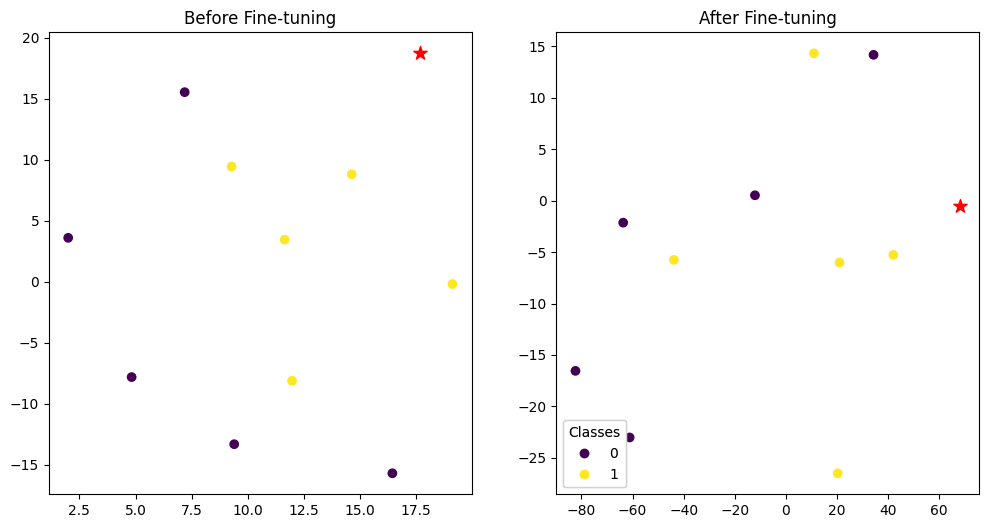

In [ ]:
# Combine query and document embeddings (before fine-tuning)
all_embeddings_before = [query_embedding] + corpus_embeddings
# Combine query and document embeddings (after fine-tuning)
all_embeddings_after = [query_embedding_FT] + corpus_embeddings_FT

# Concatenate all embeddings and move them to CPU for further processing
all_embeddings_before_tensor = torch.cat(all_embeddings_before, dim=0).cpu()  # Concatenate and move to CPU
all_embeddings_after_tensor = torch.cat(all_embeddings_after, dim=0).cpu()  # Concatenate and move to CPU

# Create labels where 0 corresponds to the query, and the rest to documents
all_labels = [0] + example_labels  # Add a label for the query (e.g., 0)

# Apply t-SNE to reduce the dimensionality of embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_before_2d = tsne.fit_transform(all_embeddings_before_tensor.numpy())  # Embeddings before fine-tuning in 2D
embeddings_after_2d = tsne.fit_transform(all_embeddings_after_tensor.numpy())  # Embeddings after fine-tuning in 2D

# Extract query and document embeddings (before and after fine-tuning) for plotting
query_embedding_before_2d = embeddings_before_2d[0]  # Query embedding before fine-tuning
corpus_embeddings_before_2d = embeddings_before_2d[1:]  # Document embeddings before fine-tuning

query_embedding_after_2d = embeddings_after_2d[0]  # Query embedding after fine-tuning
corpus_embeddings_after_2d = embeddings_after_2d[1:]  # Document embeddings after fine-tuning

# Plot the embeddings before and after fine-tuning side by side
plt.figure(figsize=(12, 6))

# Plot for embeddings before fine-tuning
plt.subplot(1, 2, 1)
scatter = plt.scatter(corpus_embeddings_before_2d[:, 0], corpus_embeddings_before_2d[:, 1], c=example_labels, label='Documents')  # Plot documents
plt.scatter(query_embedding_before_2d[0], query_embedding_before_2d[1], c='red', marker='*', s=100, label='Query')  # Highlight the query embedding
plt.title('Before Fine-tuning')  # Add title


# Plot for embeddings after fine-tuning
plt.subplot(1, 2, 2)
scatter = plt.scatter(corpus_embeddings_after_2d[:, 0], corpus_embeddings_after_2d[:, 1], c=example_labels, label='Documents')  # Plot documents
plt.scatter(query_embedding_after_2d[0], query_embedding_after_2d[1], c='red', marker='*', s=100, label='Query')  # Highlight the query embedding
plt.title('After Fine-tuning')  # Add title

# Add a legend to show which colors correspond to which labels
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
plt.gca().add_artist(legend1)

# Display the plot
plt.show()

### ✏️ Observe the results above and discuss the following:
- According to the visualization, can you infer why fine-tuning leads to better IR results?
- What is t-SNE? What does it do?

從可視化效果中，右側的圖表（“微調後”）顯示了兩個類（0和1）之間更明顯的分離。屬於不同類（由不同顏色表示）的點分佈更遠，這表明模型在微調後已經學會了更好地區分它們，這種分離可以進行更準確的分類，有助於改進資訊檢索 （IR） 結果，相反，在微調之前，這些點更加混合，這使得模型更難正確分類它們，表示特定點的紅色星號在微調空間中的位置更清晰，表示特徵表示效果更好。

t-SNE是一種降維技術，主要用於可視化高維數據。它將數據縮減為 2D 或 3D，同時保留點之間的局部關係。功能：t-SNE 映射相似的數據點、在低維空間中靠得很近的數據點和相距很遠的異點。它對於可視化深度學習模型的結果以及瞭解模型在訓練後對不同類進行聚類或分類的情況特別有用。在上面的繪圖中，t-SNE 已被用於將數據的高維投影到 2D 空間中以進行可視化，它有助於顯示微調後不同類的改進聚類，直觀地驗證模型改進的性能。



## 4.2 Visualizing The Attention

Let's use the following setence as example:

In [ ]:
vis_sent = "I pulled another all-nighter trying to finish this project. Coffee has become my best friend."

### Visualizing Attention from Fine-Tuned BERT

In [ ]:
# Input text for visualization
input_text = vis_sent

# Tokenize the input text
inputs = tokenizer.encode_plus(input_text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs.get('token_type_ids')
attention_mask = inputs.get('attention_mask')

# Move inputs to the appropriate device (GPU if available)
input_ids = input_ids.to(device)
token_type_ids = token_type_ids.to(device) if token_type_ids is not None else None
attention_mask = attention_mask.to(device) if attention_mask is not None else None

# Get model outputs, ensuring to get attention weights
# The key change is here: output_attentions=True
outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Access attention weights from the outputs

# Get the tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize attention
head_view(attention, tokens)

<IPython.core.display.Javascript object>

### Visualizing Attention from Pretrained BERT

Load the pretrained BERT again (`model` has now been fine-tuned)

In [ ]:
model_pre = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)  # Adjust num_labels as needed
model_pre.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Input text for visualization
input_text = vis_sent

# Tokenize the input text
inputs = tokenizer.encode_plus(input_text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs.get('token_type_ids')
attention_mask = inputs.get('attention_mask')

# Move inputs to the appropriate device (GPU if available)
input_ids = input_ids.to(device)
token_type_ids = token_type_ids.to(device) if token_type_ids is not None else None
attention_mask = attention_mask.to(device) if attention_mask is not None else None

# Get model outputs, ensuring to get attention weights
# The key change is here: output_attentions=True
outputs = model_pre(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Access attention weights from the outputs

# Get the tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize attention
head_view(attention, tokens)

<IPython.core.display.Javascript object>

### ✏️ Observe the results above and discuss the following:
- How can we read this diagram?

Tokens：輸入句子中的標記軸表示（水平或垂直）。這些是 BERT 從句子中標記化的單詞或子詞。例如"Coffee has become my best friend."，則會出現 ”Coffee“、”project“ 和 ”friend“ 等。

每個 attention head 可以專注於句子的不同部分，這意味著每個 head 都學會了關注不同的標記關係。可視化可以選擇要顯示的組合。

在 BERT 模型的不同層之間切換, 早期的層關注較低層次的句法關係，而後面的層次關注更多的語義關係。

- What are the words that contribute the most to the relevance classification tasl?

"pulled" , another, all, trying, to , best, friend

- How are the attention scores change after fine-tuning?

微調的BERT：注意力更加集中在與任務相關的標記上, 對於相關性分類任務，注意力將轉移到對確定文檔相關性至關重要的標記上

# Assignment 2

## 1. Discussion Questions

Answer the discussion questions above (those with ✏️ icon).

## 2. Diving Deeper into Model Fine-Tuning Analysis

Refer to the following work that investigate BERT's behavior post fine-tuning:

```
    Yichu Zhou and Vivek Srikumar. 2022. A Closer Look at How Fine-tuning Changes BERT. In Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pages 1046–1061, Dublin, Ireland. Association for Computational Linguistics.
```

In Section 4 Observations and Analysis, the authors show several obsevation on how fine-tuning changes BERT. Try to replicate **at least two** of their analysis in 4.1 to 4.3 and see if their discovery aligns with yours.<br />

In [ ]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from bertviz import head_view
from transformers import BertTokenizer, BertModel

# Load the fine-tuned model from the saved checkpoint (best model)
model_finetuned = BertModel.from_pretrained('./results/checkpoint-96')

# Move the model to the appropriate device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_finetuned.to(device)

# Load the tokenizer (same as during training)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to compute Pearson correlation of distances between two sets of embeddings
def compute_spatial_similarity(embeddings_train, embeddings_test):
    # Ensure the embeddings are stacked into a uniform 2D array
    embeddings_train = np.vstack(embeddings_train)  # Stack into 2D numpy array
    embeddings_test = np.vstack(embeddings_test)    # Stack into 2D numpy array

    # Ensure train and test have the same number of samples (truncate or oversample as needed)
    min_len = min(len(embeddings_train), len(embeddings_test))
    embeddings_train = embeddings_train[:min_len]
    embeddings_test = embeddings_test[:min_len]

    # Now compute distances
    distances_train = euclidean_distances(embeddings_train)
    distances_test = euclidean_distances(embeddings_test)

    # Flatten distances and ensure both are the same length
    distances_train_flat = distances_train.flatten()
    distances_test_flat = distances_test.flatten()

    # Compute Pearson correlation
    correlation, _ = pearsonr(distances_train_flat, distances_test_flat)
    return correlation

# Extract embeddings from the BERT model for a dataset
def get_embeddings(dataset, model, tokenizer):
    embeddings = []
    for text in dataset:
        inputs = tokenizer.encode_plus(text, return_tensors='pt', truncation=True, max_length=512)
        input_ids = inputs['input_ids'].to(device)
        with torch.no_grad():
            outputs = model(input_ids)
        embeddings.append(outputs.last_hidden_state[0].cpu().numpy())  # Use last hidden state or [CLS] token
    return embeddings

# Spatial Similarity Analysis (4.1)
def analyze_spatial_similarity(train_dataset, test_dataset, model_finetuned, tokenizer):
    # Get embeddings for fine-tuned model
    finetune_train_embs = get_embeddings(train_dataset, model_finetuned, tokenizer)
    finetune_test_embs = get_embeddings(test_dataset, model_finetuned, tokenizer)

    # Compute spatial similarity for fine-tuned model
    similarity_post = compute_spatial_similarity(finetune_train_embs, finetune_test_embs)

    print(f"Spatial Similarity (Fine-tuned): {similarity_post:.4f}")

# Function to extract embeddings for a specific token
def get_token_embedding(text, model, tokenizer, token):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)

    with torch.no_grad():
        outputs = model(input_ids)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    token_idx = tokens.index(token)  # Get index of the token you want to analyze
    token_embedding = outputs.last_hidden_state[0][token_idx].cpu().numpy()  # Extract the token's embedding

    return token_embedding

# Embedding Shift Analysis (4.3)
def analyze_embedding_shifts(query_text, model_finetuned, tokenizer, token):
    finetuned_emb = get_token_embedding(query_text, model_finetuned, tokenizer, token)
    print(f"Token embedding for '{token}' after fine-tuning: {finetuned_emb}")

# Function to get attention weights for a given text
def get_attention_weights(text, model, tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    outputs = model(input_ids, output_attentions=True)
    attention = outputs.attentions  # Get attention weights
    return attention, input_ids

# Attention Pattern Visualization (4.2)
def visualize_attention_patterns(query_text, model_finetuned, tokenizer):
    attention_finetuned, input_ids_finetuned = get_attention_weights(query_text, model_finetuned, tokenizer)

    tokens_finetuned = tokenizer.convert_ids_to_tokens(input_ids_finetuned[0])

    print("Fine-tuned BERT Attention")
    head_view(attention_finetuned, tokens_finetuned)

# Main Execution
if __name__ == "__main__":
    # Replace 'corpus_FT' and 'eval_corpus' with your actual datasets
    train_dataset = corpus_FT[:100]  # Use your actual training set
    test_dataset = eval_corpus[:30]  # Use your actual test set
    query_text = "I pulled another all-nighter trying to finish this project. Coffee has become my best friend."
    token = 'pulled'

    # Load fine-tuned model and tokenizer
    analyze_spatial_similarity(train_dataset, test_dataset, model_finetuned, tokenizer)
    analyze_embedding_shifts(query_text, model_finetuned, tokenizer, token)
    visualize_attention_patterns(query_text, model_finetuned, tokenizer)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Spatial Similarity (Fine-tuned): 0.0585
Token embedding for 'pulled' after fine-tuning: [-2.90999442e-01  4.98069823e-01  1.12979925e+00  2.70950049e-01
 -3.36408824e-01 -2.98594832e-01  2.37081796e-01 -2.16804609e-01
  7.29760587e-01  4.83625531e-01 -2.31424794e-01  4.42512721e-01
  3.78093183e-01  3.31105441e-01  1.43066630e-01  6.79599196e-02
  3.20896432e-02  4.71960194e-02 -3.57165605e-01 -5.84596070e-03
  5.21807432e-01 -3.95204909e-02 -2.68143583e-02  9.65914786e-01
  4.87744361e-01 -8.97020519e-01 -4.44797337e-01 -8.90060782e-01
 -1.49813324e-01  6.23794943e-02 -3.49899799e-01 -5.77265993e-02
  7.11140096e-01 -2.03661203e-01  3.21588129e-01  9.07011107e-02
  2.58661389e-01 -5.86856902e-01  1.19784046e-02  1.17647097e-01
 -3.94085906e-02 -4.15334344e-01 -7.30274975e-01 -4.99686807e-01
  4.46736142e-02  6.50456250e-01  2.78792620e-01  6.78256378e-02
  5.29637113e-02 -4.68427718e-01 -1.30891994e-01 -4.04181182e-01
  9.53599215e-01  1.51011601e-01 -1.01392873e-01  3.35451394e-01
  

<IPython.core.display.Javascript object>

## 3. **Bonus Question:** Cross-Encoder IR with BERT

In our previous and current lab activity, we simply use BERT as an encoder to obtain query and document representations. We then rank the documents based on their cosine similarity to the query. This is called a **bi-encoder** or **dual encoder** structure. There is another structure called a **cross encoder**, where we do not learn the representations of the query and document separately. Instead, we concatenate them together as a single input to BERT, and classify the resulting representation as a relevant or irrelevant sentence pair. An illustration of the two encoders is shown below:<br />
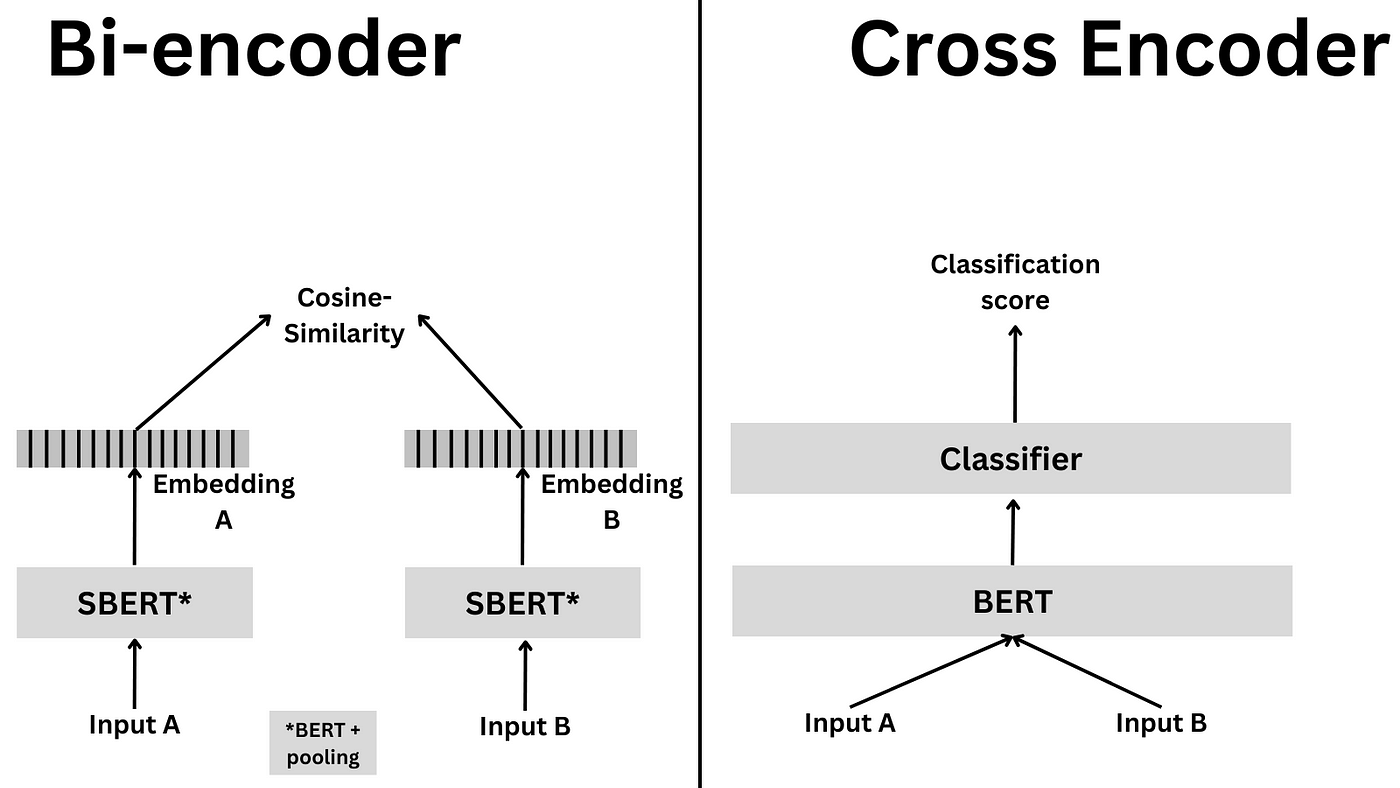

Implement a cross-encoder IR system using BERT. Fine-tune the model and compare its performance to the bi-encoder IR system.

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Load tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a function to concatenate the query and document as a single input
def encode_query_document_pairs(query, documents):
    inputs = []
    for doc in documents:
        combined_text = query + " [SEP] " + doc
        encoded = tokenizer.encode_plus(
            combined_text,
            return_tensors="pt",
            max_length=512,
            padding="max_length",
            truncation=True
        )
        inputs.append(encoded)
    return inputs

# Example data (query and document pairs)
query = "What are the effects of sleep deprivation?"
documents = [
    "Sleep deprivation has been linked to various health issues.",
    "The sky is blue and clear today.",
    "Chronic lack of sleep can lead to serious health conditions."
]

# Encode query-document pairs
encoded_pairs = encode_query_document_pairs(query, documents)

# Create dataset with labels (1 for relevant, 0 for irrelevant)
data = {
    'input_ids': [pair['input_ids'][0] for pair in encoded_pairs],
    'attention_mask': [pair['attention_mask'][0] for pair in encoded_pairs],
    'label': [1, 0, 1]  # Assume the first and third documents are relevant
}

dataset = Dataset.from_dict(data)

# Prepare for fine-tuning
training_args = TrainingArguments(
    output_dir='./cross_encoder_results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_steps=10,
    load_best_model_at_end=True
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset  # You would use a separate evaluation set here
)

# Fine-tune the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=3, training_loss=0.6308816274007162, metrics={'train_runtime': 2.4539, 'train_samples_per_second': 3.668, 'train_steps_per_second': 1.223, 'total_flos': 2367999498240.0, 'train_loss': 0.6308816274007162, 'epoch': 3.0})

In [ ]:
# Function to rank documents using the fine-tuned cross-encoder model
def rank_documents_cross_encoder(query, documents, model, tokenizer):
    scores = []
    for idx, doc in enumerate(documents):
        combined_text = query + " [SEP] " + doc
        inputs = tokenizer(combined_text, return_tensors="pt", max_length=512, truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Move to the same device as the model
        with torch.no_grad():
            outputs = model(**inputs)
        score = outputs.logits[0][1].item()  # Take the score for the relevant class (1)
        scores.append((idx, score))
    return sorted(scores, key=lambda x: x[1], reverse=True)

query = "What are the effects of sleep deprivation?"
documents = [
    "Sleep deprivation has been linked to various health issues.",
    "The sky is blue and clear today.",
    "Chronic lack of sleep can lead to serious health conditions."
]

# Rank documents based on the query using the cross-encoder
rankings_cross_encoder = rank_documents_cross_encoder(query, documents, model, tokenizer)
print("Cross-Encoder Rankings:", rankings_cross_encoder)


Cross-Encoder Rankings: [(0, 0.5199677348136902), (2, 0.36029574275016785), (1, 0.25116652250289917)]


In [ ]:
def get_bert_embedding(text, model, tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    input_ids = inputs['input_ids'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, output_hidden_states=True)

    if outputs.hidden_states:
        return outputs.hidden_states[-1][:, 0, :].cpu().numpy()  # Move to CPU before converting to NumPy
    elif hasattr(outputs, 'last_hidden_state'):
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Fallback to last_hidden_state


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Get the 2D embeddings for the [CLS] token for both query and documents
query_embedding = get_bert_embedding(query, model, tokenizer)  # Shape should be (1, hidden_size)
document_embeddings = [get_bert_embedding(doc, model, tokenizer) for doc in documents]  # Each should be (1, hidden_size)

# Now compute cosine similarity using the flattened embeddings (2D arrays)
rankings_bi_encoder = [
    (i, cosine_similarity([query_embedding.flatten()], [doc_embedding.flatten()])[0][0])
    for i, doc_embedding in enumerate(document_embeddings)
]

# Sort the rankings by similarity score
rankings_bi_encoder = sorted(rankings_bi_encoder, key=lambda x: x[1], reverse=True)

print("Bi-Encoder Rankings:", rankings_bi_encoder)


Bi-Encoder Rankings: [(1, 0.8370995), (0, 0.81516594), (2, 0.8004092)]


In [ ]:
def compute_mrr(rankings, relevance_labels):
    for rank, (doc_idx, score) in enumerate(rankings, start=1):
        if relevance_labels[doc_idx] == 1:  # If document is relevant
            return 1 / rank
    return 0

relevance_labels = [1, 0, 1]  # Document 0 and 2 are relevant

mrr_bi_encoder = compute_mrr(rankings_bi_encoder, relevance_labels)
mrr_cross_encoder = compute_mrr(rankings_cross_encoder, relevance_labels)

print(f"Bi-Encoder MRR: {mrr_bi_encoder}")
print(f"Cross-Encoder MRR: {mrr_cross_encoder}")


Bi-Encoder MRR: 0.5
Cross-Encoder MRR: 1.0


In [ ]:
!jupyter nbconvert --clear-output --inplace MIS590_W6_Lab_Exercise.ipynb
!jupyter nbconvert --to html MIS590_W6_Lab_Exercise.ipynb


[NbConvertApp] Converting notebook MIS590_W6_Lab_Exercise.ipynb to notebook
[NbConvertApp] Writing 266682 bytes to MIS590_W6_Lab_Exercise.ipynb
[NbConvertApp] Converting notebook MIS590_W6_Lab_Exercise.ipynb to html
[NbConvertApp] Writing 928056 bytes to MIS590_W6_Lab_Exercise.html


## 💻 Assignment Submission 💻
Write your code and display the results in this Jupyter Notebook. Then, export it as an HTML file and submit both the Jupyter Notebook and the HTML file to Cyber University. (I will show you how to download this notebook and export HTML in class) </br>
**Please ensure that the code is executed and the outputs are visible when exporting the HTML file.**